In [1]:
import re
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import time
import os
from os import listdir
from os.path import isfile, join
module_path = '../'
if module_path not in sys.path:
    sys.path.append(module_path)
from detectors import NonparametricInfluenceFunctionDetector

In [2]:
dataset = "SMAP_MSL"
data_path = Path("../../data/multivariate/") / dataset
test_df = pd.read_csv(data_path/"labeled_anomalies.csv")
smap_df = test_df.loc[test_df.spacecraft == "SMAP"]
# remove P-2 since anomaly transformer also removes this channel
df = smap_df.loc[smap_df.chan_id != "P-2"]
# msl_df = test_df.loc[test_df.spacecraft == "MSL"]

### SMAP

In [11]:
class Config:
    def __init__(self):
        self.win_size = 25
        self.data_path = './data_processed/SMAP'
        self.dimensions = [0]
        self.dataset = 'SMAP'
        self.verbose = False
        self.n_subsets = 200
        self.subset_frac = 0.7
        self.loss_function = "mean_squared_error"
        self.learner = "GradientBoosting"

df = smap_df.loc[smap_df.chan_id != "P-2"]
config = Config()
detector = NonparametricInfluenceFunctionDetector(config)

anomaly ratio is 8.795 %.
start detection for channel P-1 ..
block length is 25 time points.


100%|██████████████████████████████████████| 8480/8480 [00:11<00:00, 710.55it/s]


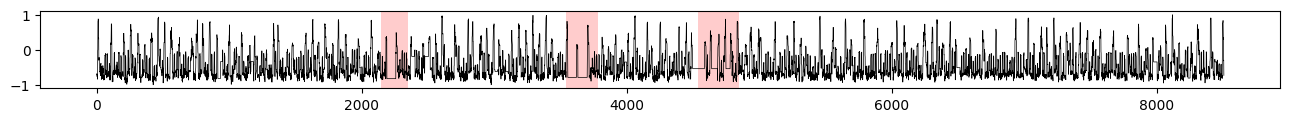

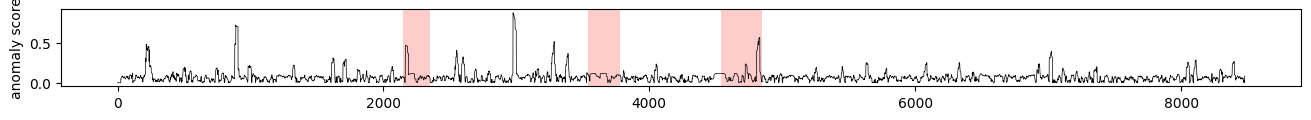

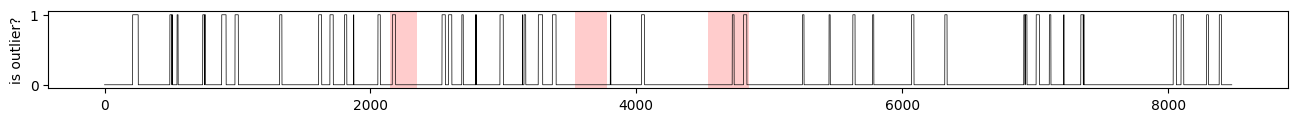

Threshold:0.14
eval w/o point adjustment:
precision: 0.086 recall: 0.086 F1: 0.086 AUC: 0.635
eval with point adjustment:
precision: 0.427 recall: 0.679 F1: 0.524 AUC: 0.635


In [12]:
len_test_dict, len_anomaly_dict, len_ratio_dict = {}, {}, {}
prec_dict, rec_dict, f1_dict, auc_dict, best_f1_dict = {}, {}, {}, {}, {}
prec_adj_dict, rec_adj_dict, f1_adj_dict = {}, {}, {}
time_dict = {}

for channel in df.chan_id:

    if config.dimensions is not None:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")[:,config.dimensions]
    else:
        ts_test = np.load(data_path/"test"/f"{channel}.npy")

    # import ipdb
    # ipdb.set_trace()

    seq_len = len(ts_test)
    anomaly_seqs = df.loc[df.chan_id == channel].anomaly_sequences.to_numpy().item()
    anomaly_seqs = re.findall(r'\d+', anomaly_seqs)
    anomaly_intervals = []
    for i in list(range(0, len(anomaly_seqs), 2)):
        anomaly_intervals.append(anomaly_seqs[i:i+2])
    anomaly_intervals = np.array(anomaly_intervals).astype(int)

    ground_truth = np.zeros(ts_test.shape[0])
    plt.figure(figsize=(16,1))
    plt.plot(ts_test, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.

    anomaly_len = sum(ground_truth)
    anomaly_ratio = anomaly_len / seq_len
    print(f"anomaly ratio is {anomaly_ratio * 100.:.3f} %.")

    len_test_dict.update({channel: seq_len})
    len_anomaly_dict.update({channel: anomaly_len})
    len_ratio_dict.update({channel: anomaly_ratio})

    print(f"start detection for channel {channel} ..")
    start_time = time.time()
    anomaly_scores = detector.calculate_anomaly_scores(ts = ts_test, channel_id = channel, contamination = min(anomaly_ratio,0.5)) # contamination has to be inthe range (0.0,0.5]
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 3)
    
    plt.figure(figsize=(16,1))
    loos_viz = np.ones(len(ts_test)) * np.nan
    loos_viz[:len(anomaly_scores)] = anomaly_scores
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("anomaly score")
    plt.show()
    
    detected_outliers = anomaly_scores > np.quantile(anomaly_scores, 1-anomaly_ratio) #
    plt.figure(figsize=(16,1))
    loos_viz = np.ones(len(ts_test)) * np.nan
    loos_viz[:len(detected_outliers)] = detected_outliers
    plt.plot(loos_viz, c="k", linewidth=.5)
    for anomaly_points in anomaly_intervals:
        plt.axvspan(anomaly_points[0], anomaly_points[-1], facecolor='red', alpha=.2)
        ground_truth[anomaly_points[0]:anomaly_points[-1]] = 1.
    plt.ylabel("is outlier?")
    plt.show()
    
    prec, rec, f1, auc, prec_adj, rec_adj, f1_adj,  best_f1 = detector.evaluate(ground_truth, anomaly_scores, anomaly_ratio)

    prec_dict.update({channel: prec})
    rec_dict.update({channel: rec})
    f1_dict.update({channel: f1})
    auc_dict.update({channel: auc})
    best_f1_dict.update({channel: best_f1})

    time_dict.update({channel: elapsed_time})

    prec_adj_dict.update({channel: prec_adj})
    rec_adj_dict.update({channel: rec_adj})
    f1_adj_dict.update({channel: f1_adj})

    break # remove this!

smap_metrics = pd.DataFrame({
    "Num_of_Test": len_test_dict,
    "Len_of_Anomaly": len_anomaly_dict,
    "Anomaly_Ratio": len_ratio_dict,
    "Precision(w.o. Adjustment)": prec_dict,
    "Recall(w.o. Adjustment)": rec_dict,
    "F1(w.o. Adjustment)": f1_dict,
    "Precision(w. Adjustment)": prec_adj_dict,
    "Recall(w. Adjustment)": rec_adj_dict,
    "F1(w. Adjustment)": f1_adj_dict,
    "Best_F1_Score": best_f1_dict,
    "AUC": auc_dict,
    'Detection_Time(s)': time_dict
})

smap_metrics.insert(0, "Dataset", smap_metrics.index)
smap_metrics.reset_index(drop = True, inplace = True)